# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount("/gdrive")
# Change if necessary
%cd /gdrive/My Drive/Uni/Magistrale/Poli/Artificial Neural Networks and Deep Learning/challenges/challenge2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Uni/Magistrale/Poli/Artificial Neural Networks and Deep Learning/challenges/challenge2


## ⚙️ Import Libraries

In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

import numpy as np
import pandas as pd

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import scipy


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

from datetime import datetime
import pandas as pd

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load the Data

In [3]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

# Separiamo il train set in training e validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42  # 20% per il validation set
)

# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
###
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)

print(f"Training X shape: {X_train.shape}")
print(f"Validation X shape: {X_val.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2092, 64, 128, 1)
Validation X shape: (523, 64, 128, 1)
Training y shape: (2092, 64, 128)
Test X shape: (10022, 64, 128, 1)


In [4]:
category_map = {
  0: 0, #Background
  1: 1, #Soil
  2: 2, #Bedrock
  3: 3, #Sand
  4: 4, #Big Rock
}

In [5]:
def visualize_image_label_pairs(X, y, num_images, class_names, reverse=0):
    """
    Visualize pairs of original images and their corresponding label overlays,
    and add a color legend for the labels.

    Args:
        X: Array of images (shape: [num_samples, height, width, channels]).
        y: Array of labels (shape: [num_samples, height, width]).
        num_images: Number of image-label pairs to visualize.
        class_names: List of class names (optional). If provided, a legend will be added.
    """

    if reverse == 1:
        X = X[::-1]
        y = y[::-1]

    # Set up the grid layout: 2 columns, num_images rows
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

    # Define a custom colormap for the legend
    if class_names is not None:
        cmap = mcolors.ListedColormap(plt.cm.jet(np.linspace(0, 1, len(class_names))))
        norm = mcolors.BoundaryNorm(np.arange(len(class_names)+1), len(class_names))
    else:
        cmap = 'jet'
        norm = None

    for i in range(num_images):
        # Extract the image and its corresponding label
        image = X[i]
        label = y[i]

        # Show the original image in the first column
        ax = axes[i, 0] if num_images > 1 else axes[0]
        ax.imshow(image.squeeze(), cmap='gray')  # Use squeeze for grayscale images
        ax.axis('off')
        ax.set_title(f"Image {i+1}")

        # Show the image with the label overlay in the second column
        ax = axes[i, 1] if num_images > 1 else axes[1]
        ax.imshow(image.squeeze(), cmap='gray')  # Background: original image
        ax.imshow(label, alpha=0.5, cmap=cmap, norm=norm)  # Label overlay
        ax.axis('off')
        ax.set_title(f"Label Overlay {i+1}")

    # Add the legend if class names are provided
    if class_names is not None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(len(class_names))]
        plt.legend(handles, class_names, title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

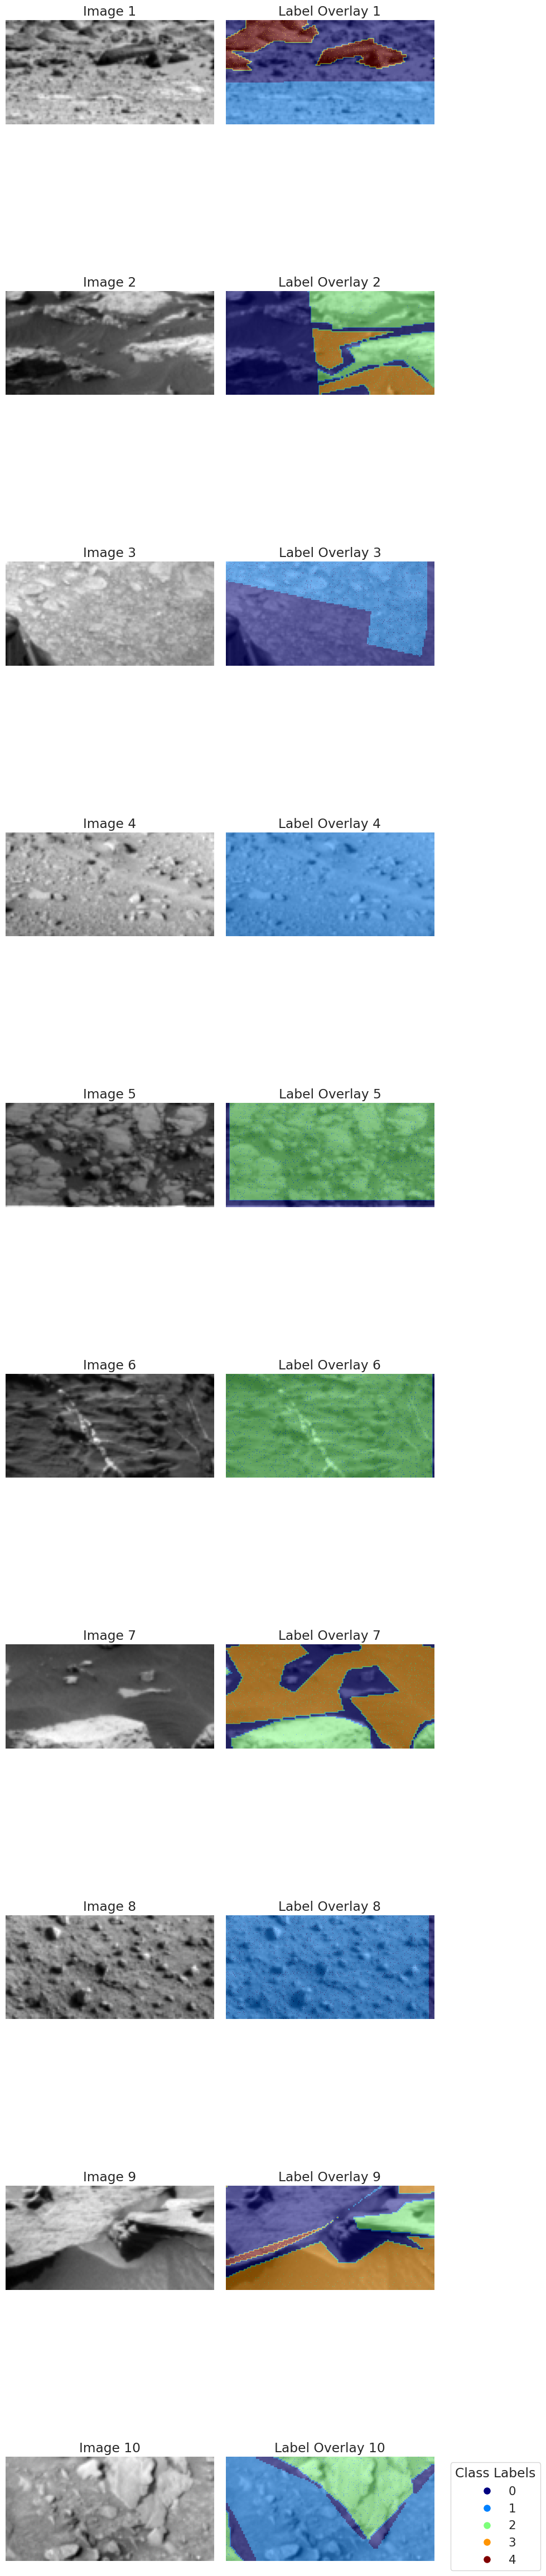

In [6]:
visualize_image_label_pairs(X_train, y_train, num_images=10, class_names=category_map, reverse=0)

In [7]:
def visualize_image_label_pair(X, y, index, class_names=None):
    """
    Visualize a single original image and its corresponding label overlay,
    with an optional color legend for the labels.

    Args:
        X: Array of images (shape: [num_samples, height, width, channels]).
        y: Array of labels (shape: [num_samples, height, width]).
        index: Index of the image-label pair to visualize.
        class_names: List of class names (optional). If provided, a legend will be added.
    """

    # Extract the image and its corresponding label
    image = X[index]
    label = y[index]

    # Set up the grid layout: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Define a custom colormap for the legend
    if class_names is not None:
        cmap = mcolors.ListedColormap(plt.cm.jet(np.linspace(0, 1, len(class_names))))
        norm = mcolors.BoundaryNorm(np.arange(len(class_names)+1), len(class_names))
    else:
        cmap = 'jet'
        norm = None

    # Show the original image in the first column
    axes[0].imshow(image.squeeze(), cmap='gray')  # Use squeeze for grayscale images
    axes[0].axis('off')
    axes[0].set_title("Original Image")

    # Show the image with the label overlay in the second column
    axes[1].imshow(image.squeeze(), cmap='gray')  # Background: original image
    axes[1].imshow(label, alpha=0.5, cmap=cmap, norm=norm)  # Label overlay
    axes[1].axis('off')
    axes[1].set_title("Label Overlay")

    # Add the legend if class names are provided
    if class_names is not None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(len(class_names))]
        fig.legend(handles, class_names, title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

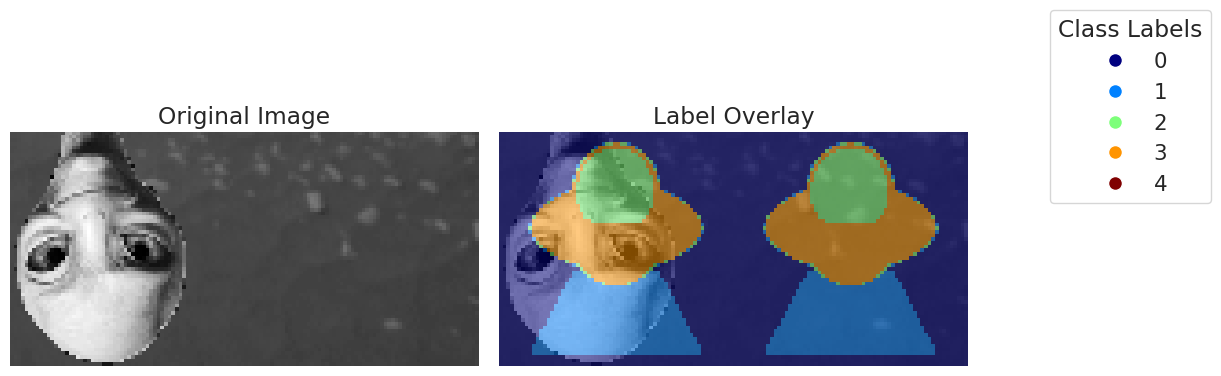

In [8]:
# 👽 Found!!!
alien_index = 62

visualize_image_label_pair(X_train, y_train, alien_index, class_names=category_map)

### 👽 Alien Removal

110 Aliens found!!


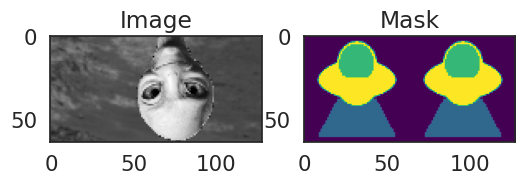

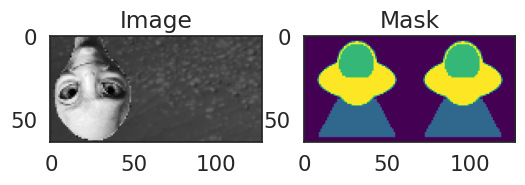

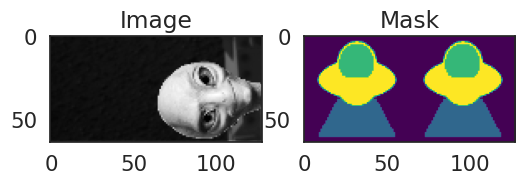

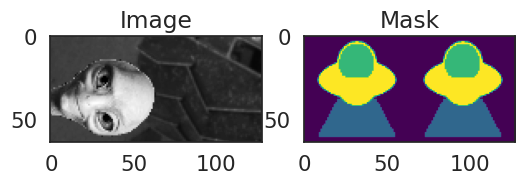

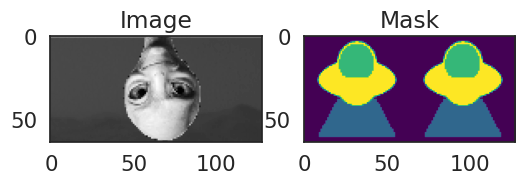

In [9]:
images = training_set[:, 0, :, :]
masks = training_set[:, 1, :, :]

alien_mask = masks[alien_index]


duplicate_indices = np.where((masks == alien_mask).all(axis=(1, 2)))[0]

print(f"{len(duplicate_indices)} Aliens found!!")

# Visualize all samples with the most duplicated mask
for idx in duplicate_indices[:5]:
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(images[idx], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(masks[idx], cmap="viridis")
    plt.show()


In [10]:

filtered_indices = ~np.isin(range(len(masks)), duplicate_indices)
filtered_training_set = training_set[filtered_indices]


out_filename = "mars_for_students_no_aliens.npz"


np.savez(out_filename, training_set=filtered_training_set, test_set=data["test_set"])

print(f"Filtered dataset saved as {out_filename}")

Filtered dataset saved as mars_for_students_no_aliens.npz
